<a href="https://colab.research.google.com/github/suradathb/NoobVue-V1/blob/master/keras_general_classifier_98_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_file = "/content/drive/My Drive/Colab Notebooks/model_bird.zip"

In [4]:
import zipfile

with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

In [5]:
def wrapup (output_dir,subject, accuracy, image_size, model, weights,run_num, kaggle):
    if accuracy >= 95:
        msg=f'With an accuracy of {accuracy:5.2f} % the results appear satisfactory'
        print_in_color(msg, (0,255,0),(0,0,0))
        if kaggle:
            save_model(output_dir, subject, accuracy, image_size ,model_size, model, weights)            
            print ('*********************Process is completed******************************')            
            return [False, None]        
    elif accuracy >=85 and accuracy < 95:
        if kaggle:
            if run_num==2:
                save_model(output_dir, subject, accuracy, image_size ,model_size, model, weights) 
                print ('*********************Process is completed******************************')
                return [False, None]
            else:
                print('running for 6 more epochs to see if accuracy improves')
                return[True,6] # run for 8 more epochs
        else:
            msg=f'With an accuracy of {accuracy:5.2f} % the results are mediocure. Try running more epochs'
            print_in_color(msg, (255,0,0),(0,0,0))
            
    else:
        if kaggle:
            if run_num==2:
                save_model(output_dir, subject, accuracy, image_size ,model_size, model, weights) 
                print ('*********************Process is completed******************************')
                return [False, None]
            else:
                print('Running for 8 more epochs to see if accuracy improves')
                return[True,8] # run for 8 more epochs
        else:
            msg=f'With an accuracy  of {accuracy:5.2f} % the results would appear to be unsatisfactory'
            print_in_color(msg, (255,0,0),(0,0,0))
            msg='You might try to run for more epochs or get more training data '
            msg=msg + 'or perhaps crop your images so the desired subject takes up most of the image'
            print_in_color(msg, (255,255,255), (0,0,0))
            
    
    tryagain=True
    if kaggle==False:
        while tryagain==True:
            ans=input('To continue training from where it left off enter the number of additional epochs or enter H to halt  ')
            if ans =='H' or ans == 'h':
                run=False
                tryagain=False
                save_model(output_dir, subject, accuracy, image_size ,model_size, model, weights) 
                print ('*********************Process is completed******************************')
                return [run,None]
            else:
                try:
                    epochs=int(ans)
                    run=True
                    tryagain=False
                    return [run,epochs]
                except ValueError:
                    msg=f'\nyour entry {ans} was neither H nor an integer- re-enter your response'
                    print_in_color(msg, (255,0,0), (0,0,0))

In [6]:
def display_pred(output_dir, pred, file_names, labels, subject, model_size,classes, kaggle):    
    trials=len(labels)
    errors=0
    e_list=[]
    prob_list=[]
    true_class=[]
    pred_class=[]
    x_list=[]
    index_list=[]
    pr_list=[]
    error_msg=''    
    for i in range (0,trials):
        p_class=pred[i].argmax()
        if p_class !=labels[i]: #if the predicted class is not the same as the test label it is an error
            errors=errors + 1
            fname=os.path.basename(file_names[i])
            e_list.append(fname)  # list of file names that are in error
            true_class.append(classes[labels[i]]) # list classes that have an eror
            pred_class.append(classes[p_class]) #class the prediction selected
            prob_list.append(100 *pred[i][p_class])# probability of the predicted class
            add_msg='{0:^24s}{1:5s}{2:^20s}\n'.format(classes[labels[i]], ' ', file_names[i])
            error_msg=error_msg + add_msg
            
    accuracy=100*(trials-errors)/trials
    msg=f'\n There were {errors} errors in {trials} trials for an accuracy of {accuracy:7.3f}'
    print_in_color(msg, (0,255,0),(0,0,0))
    if kaggle==True and errors<26:
        ans='Y'
    else:
        ans='N'
    if kaggle==False:
        ans=input('To see a listing of prediction errors enter Y to skip press Enter\n ')
    if ans== 'Y' or ans  =='y':
        msg='{1:^20s}{0:3s}{2:^20s}{0:3s}{3:^20s}{0:5s}{4}'
        msg=msg.format( ' ', 'File Name', 'True Class', 'Predicted Class', 'Probability')
        print_in_color(msg, (0,0,255), (255,255,0))
        for i in range(0,errors):
            msg='{0}{1:^20s}{0:3s}{2:^20s}{0:3s}{3:^20s}{0:5s}{4:^6.2f}'
            print (msg.format(' ',e_list[i], true_class[i], pred_class[i], prob_list[i]))
    if kaggle==True:
        ans='Y'
    else:
        ans=input('\nDo you want to save the list of error files?. Enter Y to save or press Enter to not save  ')
    if ans=='Y' or ans=='y':
        acc='{0:6.2f}'.format(accuracy)
        if model_size=='L':
            ms='Large'
        elif model_size=='M':
            ms= 'Medium'
        else:
            ms= 'Small'
        header='Classification subject: {0} There were {1} errors in {2} tests for an accuracy of {3} using a {4} model\n'.format(subject,errors,trials,acc,ms)
        header= header +'{0:^24s}{1:5s}{2:^20s}\n'.format('CLASS',' ', 'FILENAME') 
        error_msg=header + error_msg
        file_id='error list-' + model_size + acc +'.txt'
        file_path=os.path.join(output_dir,file_id)
        f=open(file_path, 'w')
        f.write(error_msg)
        f.close()
    for c in classes:
        count=true_class.count(c)
        x_list.append(count)
        pr_list.append(c)
    for i in range(0, len(x_list)):  # only plot classes that have errors
        if x_list[i]==0:
            index_list.append(i)
    for i in sorted(index_list, reverse=True):  # delete classes with no errors
        del x_list[i]
        del pr_list[i]      # use pr_list - can't change class_list must keep it fixed
    fig=plt.figure()
    fig.set_figheight(len(pr_list)/4)
    fig.set_figwidth(6)
    plt.style.use('fivethirtyeight')
    for i in range(0, len(pr_list)):
        c=pr_list[i]
        x=x_list[i]
        plt.barh(c, x, )
        plt.title( subject +' Classification Errors on Test Set')
    if errors>0:
        plt.show()
    if kaggle==False:
        ans=input('Press Enter to continue')
    return accuracy        

In [7]:
def save_model(output_dir,subject, accuracy, image_size,model_size, model, weights):
    # save the model with the  subect-accuracy.h5
    acc=str(accuracy)[0:5]
    id=subject + '-' + model_size + '-' +str(image_size) + '-' + acc + '.h5'    
    id1=subject + '-' + model_size + '-' +str(image_size) + '-' + acc + '.tf'    
    model.set_weights(weights)
    model_save_path=os.path.join(output_dir,id)    
    model_save_path1=os.path.join(output_dir,id1)  

    model.save(model_save_path)      
    model.save(model_save_path1)   

In [8]:
def make_predictions( model, weights, test_gen, lr):
    config = model.get_config()
    pmodel = Model.from_config(config)  # copy of the model
    pmodel.set_weights(weights) #load saved weights with lowest validation loss
    pmodel.compile(Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])    
    print('Training has completed. Now loading test set to see how accurate the model is')
    results=pmodel.evaluate(test_gen, verbose=0)
    accuracy=results[1]*100
    print('Model accuracy on Test Set is {0:7.2f} %'.format(results[1]* 100))
    predictions=pmodel.predict_generator(test_gen, verbose=0)        
    return (predictions,accuracy)

In [9]:
def tr_plot(tacc,vacc,tloss,vloss):
    #Plot the training and validation data
    Epoch_count=len(tloss)
    Epochs=[]
    for i in range (0,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    val_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1)
    vc_label='best epoch= '+ str(index_acc + 1)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1,val_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [10]:
def train(model, callbacks, generators, epochs,start_epoch):
    # steps_list[0]=training steps, steps_list[2]=validations steps
    start=time.time()
    data = model.fit_generator(generator = generators[0], validation_data= generators[2], 
                               epochs=epochs, initial_epoch=start_epoch,
                               callbacks = callbacks, verbose=1)
    #data=model.fit(x=generators[0],  epochs=epochs, verbose=1, 
    #               callbacks=callbacks,  validation_data=generators[2], shuffle=True,  initial_epoch=start_epoch) 
       
    stop=time.time()
    duration = stop-start
    hrs=int(duration/3600)
    mins=int((duration-hrs*3600)/60)
    secs= duration-hrs*3600-mins*60
    msg=f'Training took\n {hrs} hours {mins} minutes and {secs:6.2f} seconds'
    print_in_color(msg, (0,0,255),(0,0,0))
    return data

In [11]:
def make_model(classes,lr_rate, image_size,model_size,dropout, rand_seed):
    size=len(classes)
    mobile = tf.keras.applications.mobilenet.MobileNet( include_top=False,
                                                           input_shape=(image_size,image_size,3),
                                                           pooling='max', weights='imagenet',
                                                           alpha=1, depth_multiplier=1,dropout=.4)
    x=mobile.layers[-1].output
    if model_size=='S':
        pass
       # x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                #bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
        #x=Dropout(rate=dropout, seed=rand_seed)(x) 
    elif model_size=='M':
        x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x) 
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x=Dense(16, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x)
    else:
        x=Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x) 
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x)
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x=Dense(16, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x)        
    x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    predictions=Dense (len(classes), activation='softmax')(x)
    model = Model(inputs=mobile.input, outputs=predictions)    
    for layer in model.layers:
        layer.trainable=True
    model.compile(Adamax(lr=lr_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [12]:
def make_generators( paths, mode, split, classes, image_size, rand_seed):
    #paths[0]=train path,paths[1]=test path paths[2]= valid path paths[3]=classes
    split=split/100.0    
    if image_size==224:
        batch_size=85
    elif image_size==192:
        batch_size=120
    elif image_size==160:
        batch_size=170
    else:
        batch_size=260
    if mode == 'SEP': 
        train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(paths[0],
                target_size=(image_size, image_size), batch_size=batch_size, seed=rand_seed, class_mode='categorical', color_mode='rgb')
        
        valid_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) .flow_from_directory(paths[2], 
                target_size=(image_size, image_size), batch_size=batch_size,
                seed=rand_seed, class_mode='categorical',color_mode='rgb', shuffle=False)
        
        test_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(paths[1],
                target_size=(image_size, image_size), batch_size=batch_size, class_mode='categorical',color_mode='rgb',
                seed=rand_seed, shuffle=False )
        file_names=test_gen.filenames          
        labels=test_gen.labels               
        return [[train_gen, test_gen, valid_gen], file_names, labels]                  
    else:        
        # all data is in a single directory there are no test images use validation images as test images
        train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                             validation_split=split).flow_from_directory(paths[0],
                                                                                    target_size=(image_size, image_size),
                                                                                    batch_size=batch_size,
                                                                                    subset='training',seed=rand_seed)
        valid_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                    validation_split=split).flow_from_directory(paths[0],
                                                                                    target_size=(image_size, image_size),
                                                                                    batch_size=batch_size,
                                                                                    subset='validation',
                                                                                    seed=rand_seed, shuffle=False)
        file_names= valid_gen.filenames
        labels= valid_gen.labels
    return [[train_gen, valid_gen, valid_gen], file_names, labels]

In [13]:
def get_paths(source_dir,output_dir,mode,subject,classes): 
    class_count=len(classes)
    if mode =='ALL':
        # all data is in a single directory must be split into train, test, valid data sets 
        train_path=source_dir
        test_path=None        
        valid_path=None       
    else:
        # data is seperated in 3 directories train, test, valid
        test_path=os.path.join(source_dir,'test')
        train_path=os.path.join(source_dir, 'train')
        valid_path=os.path.join(source_dir,'valid')                  
    # save the class dictionary as a text file so it can be used by predictor.py in the future
    #saves file as subject.txt  structure is similar to a python dictionary
    msg=''
    for i in range(0, class_count):
        msg=msg + str(i) + ':' + classes[i] +','
    id=subject +'-' + str(class_count)  + '.txt'   
    dict_path=os.path.join (output_dir, id)
    f=open(dict_path, 'w')
    f.write(msg)
    f.close()    
    return [train_path, test_path, valid_path]
      

In [14]:
def check_inputs(source_dir, out_dir, split, image_size,model_size,dropout):
    status=True
    if os.path.isdir(source_dir)==False:
        msg=f'The source directory you specified {source_dir} does not exist - program terminating'
        status=False
    elif len(os.listdir(source_dir))<2:
        msg=f'directory {source_dir} must have at least 2 sub directories'
        status=False
    elif image_size not in [224,192,160,128]:
        msg=f'the images size you specified {image_size} is not one of 224,192,160 or 128 - program terminating' 
        status=False
    elif dropout <0.0 or dropout>1.0:
        msg=f'The drop out value you specified {dropout} must be a value between 0.0 and 1.0 - program terminating'
        status=False
    elif model_size not in ['L', 'M', 'S']:
        msg=f'The model size you specified {model_size} must be as single charater string either L, M, or S'
        status=False
    elif os.path.isdir(out_dir)==False:
        msg=f'The output directory you specified {out_dir} does not exist - program terminating'
        status=False
    else:        
        status=True
        msg=f'ERROR you must have a test, train and a valid subdirectory in {source_dir}'
        source_list=os.listdir(source_dir)       
        if ('test' in source_list and 'train' not in source_list) or ('test' in source_list and 'valid' not in source_list):
            print_in_color(msg,(255,0,0),(0,0,0))
            status=False                
        elif ('train' in source_list and 'test' not in source_list) or ('train' in source_list and 'valid' not in source_list):
            print_in_color(msg,(255,0,0),(0,0,0))
            status=False                
        elif ('valid' in source_list and 'train' not in source_list) or ('valid' in source_list and 'test' not in source_list): 
            print_in_color(msg,(255,0,0),(0,0,0))
            status=False                 
        else: 
            if 'test' in source_list:
                test_path=os.path.join(source_dir,'test')
                train_path=os.path.join(source_dir,'train')
                valid_path=os.path.join(source_dir,'valid')
                test_list=sorted(os.listdir(test_path))
                train_list=sorted(os.listdir(train_path))
                valid_list=sorted(os.listdir(valid_path)) 
                for i in range (0, len(test_list)):
                    if test_list[i] != train_list[i] or test_list[i] !=valid_list[i] or train_list[i] != valid_list[i]:
                        print(i, test_list[i], train_list[i], valid_list[i])
                if train_list != test_list or train_list != valid_list or test_list !=valid_list:
                    status=False
                    msg='class directories must have identical names in the train, test and valid directories- program terminating'
                elif len(test_list) <2 or len(valid_list)<2 or len(train_list)<2:
                    status=False
                    msg=' the train, test and valid directories must have at least 2 class sub directories - program terminating'
            else:
                if len(os.listdir(source_dir))<2:
                    msg=f'The must be at least 2 subdirectories in {source_dir}'
                    status=False
                elif split==None or split<1 or split>100:
                    msg=f'the split parameter you specied {split} must be between 0 and 100 when class directories are in the source directory- program terminating'
                    status=False
                else:
                    mode='ALL'
                
    if status==False:
        print_in_color(msg, (255,0,0), (0,0,0))
        return (False, None,None)
    else:
        source_list=os.listdir(source_dir)
        if 'test' in source_list:
            mode='SEP'
            class_path=os.path.join(source_dir, 'test')
            classes=os.listdir(class_path)
        else:
            mode='ALL'
            classes=source_list
        return(True, mode, classes)

In [15]:
def TF2_classify(source_dir,out_dir,subject, split, epochs,lr_rate,image_size, model_size, dropout, rand_seed,dwell, kaggle):
    model_size=model_size.upper()
    if kaggle:
        out_dir=r'/content/sample_data'
    status, mode, classes=check_inputs(source_dir, out_dir,split, image_size,model_size, dropout) 
    if status==False:
        return False
    paths=get_paths(source_dir,output_dir,mode,subject,classes)
    generators, file_names,labels= make_generators( paths, mode, split, classes, image_size, rand_seed)
    model=make_model(classes,lr_rate, image_size,model_size,dropout, rand_seed)
    
                           
    class lradjust(tf.keras.callbacks.Callback):
        # functions in this class adjust the learning rate 
        lowest_loss=np.inf
        best_weights=model.get_weights()
        lr=float(tf.keras.backend.get_value(model.optimizer.lr))
        epoch=0
        tr_highest_acc=0        
        def __init__(self):
            super(lradjust, self).__init__()
            self.lowest_loss=np.inf
            self.best_weights=model.get_weights()
            self.lr=float(tf.keras.backend.get_value(model.optimizer.lr))
            self.epoch=0
            self.tr_highest_acc=0            
        def on_epoch_end(self, epoch, logs=None):                     
            lradjust.lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
            lradjust.epoch=lradjust.epoch +1            
            v_loss=logs.get('val_loss')  # get the validation loss for this epoch
            tr_acc=logs.get('accuracy')  # get the training accuracy for this epoch
            if lradjust.tr_highest_acc<tr_acc:  # check if the accuracy for this epoch is the highest accuracy thus far
                lradjust.tr_highest_acc=tr_acc  # replace the highest accuracy with the accuracy for this epoch
                if lradjust.tr_highest_acc<.95:  # check if accuracy exceecs .95 if it is then save the weights
                    lradjust.best_weights=model.get_weights()
                    msg=f' \n saving weights with new highest accuracy of  {lradjust.tr_highest_acc:7.4f} '
                    print_in_color(msg, (255, 255,0), (0,0,0))
            if tr_acc<=.95 and tr_acc<lradjust.tr_highest_acc:
                # reduce lr because training accuracy went below highest accuracy
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
                ratio=tr_acc/lradjust.tr_highest_acc  # add a factor to lr reduction
                new_lr=lr * .5 * ratio
                tf.keras.backend.set_value(model.optimizer.lr, new_lr)
                msg=f'\n current accuracy {tr_acc:7.4f} is below the highest accuracy of {lradjust.tr_highest_acc:7.4f},reducing learning rate to {new_lr:11.9f}'
                print_in_color(msg, (255,0,0),(0,0,0)) 
                if dwell:
                    model.set_weights(lradjust.best_weights)  # ignore the new weights and load the best weights
                    msg='\nsetting weights back to best weights'
                    print_in_color(msg,( 255,0,0),(0,0,0))
            if lradjust.lowest_loss > v_loss and lradjust.tr_highest_acc>.95:
                #accuracy is above 95% and the new validation loss is the lowest loss thus far so save the weights
                msg=f'\n validation loss improved to {v_loss:7.4f} from {lradjust.lowest_loss:7.4f} saving weights'
                print_in_color(msg, (0,255,0), (0,0,0))
                lradjust.lowest_loss=v_loss
                lradjust.best_weights=model.get_weights()
                
            else:
                 if tr_acc>.95 and lradjust.lowest_loss<v_loss:
                        # reduce learning rate based on validation loss> val.best_loss
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        ratio=lradjust.lowest_loss/v_loss  # add a factor to lr reduction
                        new_lr=lr * .7 * ratio
                        tf.keras.backend.set_value(model.optimizer.lr, new_lr)
                        msg=f'\n current validation loss {v_loss:7.4f} exceeds lowest loss of {lradjust.lowest_loss:7.4f}, reducing lr to {new_lr:11.9f}'
                        print_in_color(msg, (255,0,0), (0,0,0))
                        if dwell:
                            model.set_weights(lradjust.best_weights)  # ignore the new weights and load the best weights
                            msg='\nsetting weights back to best weights'
                            print_in_color(msg,( 255,0,0),(0,0,0))
                
    callbacks=[lradjust()] 
    run_num=0
    run=True
    tacc=[]
    tloss=[]
    vacc=[]
    vloss=[]
    start_epoch=0
    while run:
        run_num=run_num +1
        if run_num==1:
            print(' Starting Training Cycle')
        else:
            print('Resuming training from epoch {0}'.format(start_epoch))
        results=train(model,callbacks, generators, epochs,start_epoch) 
        # returns data from training the model - append the results for plotting
        tacc_new=results.history['accuracy']
        tloss_new=results.history['loss']
        vacc_new =results.history['val_accuracy']
        vloss_new=results.history['val_loss']
        for d in tacc_new:  # need to append new data from training to plot all epochs
            tacc.append(d)
        for d in tloss_new:
            tloss.append(d)
        for d in vacc_new:
            vacc.append(d)
        for d in vloss_new:
            vloss.append(d)       
        last_epoch=results.epoch[len(results.epoch)-1] # this is the last epoch run
        tr_plot(tacc,vacc,tloss,vloss) # plot the data on loss and accuracy
        bestw=lradjust.best_weights  # these are the saved weights with the lowest validation loss
        lr_rate=lradjust.lr 
        pred, accuracy=make_predictions( model, bestw, generators[1], lr_rate)
        display_pred(out_dir, pred, file_names, labels, subject, model_size,classes, kaggle)
        decide=wrapup(out_dir,subject, accuracy, image_size, model, bestw,run_num, kaggle)
        run=decide[0]        
        if run==True:
            epochs=last_epoch + decide[1]+1
            start_epoch=last_epoch +1 
        else:
            return True
        
        
            

In [16]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat))
    print('\33[0m') # returns default print color to back to black
    return

Found 31316 images belonging to 225 classes.
Found 1125 images belonging to 225 classes.
Found 1125 images belonging to 225 classes.
17227776/17225924 [==============================] - 0s 0us/step
 Starting Training Cycle
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
369/369 [==============================] - ETA: 0s - loss: 1.9081 - accuracy: 0.5681 
 saving weights with new highest accuracy of   0.5681 

369/369 [==============================] - 181s 489ms/step - loss: 1.9081 - accuracy: 0.5681 - val_loss: 1.2011 - val_accuracy: 0.6880
Epoch 2/20
369/369 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.8662 
 saving weights with new highest accuracy of   0.8662 

369/369 [==============================] - 185s 501ms/step - loss: 0.5034 - accuracy: 0.8662 - val_loss: 1.1057 - val_accuracy: 0.7004
Epoch 3/20
369/369 [==============================] - ETA: 0s - loss: 0.3253 - accuracy: 0.9088 
 saving weights with new hig

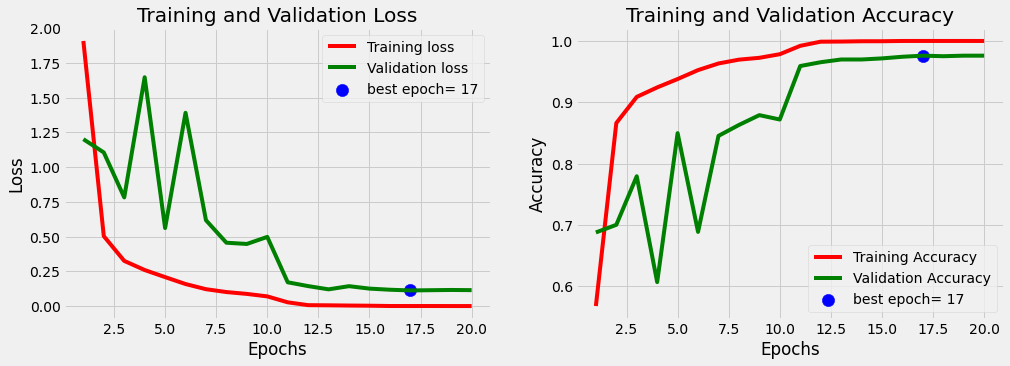

Training has completed. Now loading test set to see how accurate the model is
Model accuracy on Test Set is   98.76 %
Instructions for updating:
Please use Model.predict, which supports generators.

 There were 14 errors in 1125 trials for an accuracy of  98.756

     File Name              True Class          Predicted Class        Probability

        4.jpg             EVENING GROSBEAK       CHUKAR PARTRIDGE       76.01 
        2.jpg             NORTHERN GOSHAWK       CAPE MAY WARBLER       98.87 
        5.jpg           WHITE TAILED TROPIC      DARK EYED JUNCO        91.49 
        3.jpg                 SHOEBILL         BLACK-THROATED SPARROW     54.92 
        1.jpg                   MYNA               PARUS MAJOR          58.96 
        4.jpg             BARRED PUFFBIRD        PHILIPPINE EAGLE       52.42 
        5.jpg               TREE SWALLOW        ASIAN CRESTED IBIS      73.02 
        3.jpg                BLACK SWAN          COMMON POORWILL        92.65 
        5.jpg     

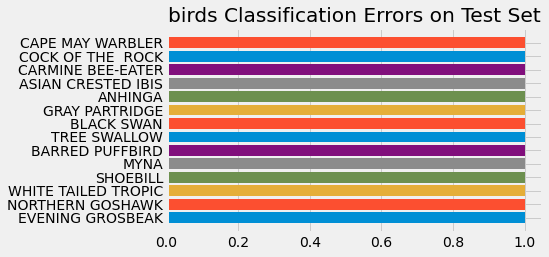

With an accuracy of 98.76 % the results appear satisfactory

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/sample_data/birds-s-224-98.75.tf/assets
*********************Process is completed******************************


In [17]:
source_dir=r'/content/100-bird-species'
output_dir=r'/content/sample_data'
subject='birds'
split=8
epochs=20
lr_rate=.005
image_size=224
model_size='s'
dropout=.1
rand_seed=12357
dwell=False
kaggle=True
status=TF2_classify(source_dir,output_dir,subject, split, epochs,lr_rate,image_size, model_size, dropout, rand_seed,dwell, kaggle)
